In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import csv
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm
import cv2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

data_location = r'/media/evan/2TB HDD/MinecraftBot/Data'

num_classes = 2  # 2 classes just object and not object
data_length = 200 # starting at 0
train_length = 191

epochs = 10
batch_size = 8

cuda


### Model Definition

In [3]:
class DoubleConv(nn.Module):
    """(Conv => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class MinecraftModel(nn.Module):
    """U-Net architecture with depth 5"""

    def __init__(self, in_channels=3, out_channels=1):
        super(MinecraftModel, self).__init__()

        # Encoder (Downsampling path)
        self.inc = DoubleConv(in_channels, 64)  # Initial conv block
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 128)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 256)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(256, 512)
        )
        self.down4 = nn.Sequential(  # New layer
            nn.MaxPool2d(2),
            DoubleConv(512, 1024)
        )

        # Decoder (Upsampling path)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv_up1 = DoubleConv(1024, 512)   # 512 from upsampling + 512 from skip connection

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_up2 = DoubleConv(512, 256)   # 256 from upsampling + 256 from skip connection

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_up3 = DoubleConv(256, 128)    # 128 from upsampling + 128 from skip connection

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_up4 = DoubleConv(128, 64)    # 64 from upsampling + 64 from skip connection

        # Output layer
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)        # Level 1
        x2 = self.down1(x1)     # Level 2
        x3 = self.down2(x2)     # Level 3
        x4 = self.down3(x3)     # Level 4
        x5 = self.down4(x4)     # Level 5 (new layer)

        # Decoder
        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.conv_up1(x)

        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv_up2(x)

        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv_up3(x)

        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv_up4(x)

        x = self.outc(x)
        output = torch.clamp(x, min=0, max=200)
        return output

In [4]:
class SimpleSegCNN(nn.Module):
    def __init__(self):
        super(SimpleSegCNN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Input: RGB image, Output: 16 channels
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
        )
        
        self.middle = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsample by 2
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2),  # Upsample by 2
            nn.ReLU(),
        )
        
        self.output_layer = nn.Conv2d(16, 57, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.encoder(x)
        
        x = self.middle(x)
        
        x = self.decoder(x)
        
        x = self.output_layer(x)
        
        return x

In [5]:
class DeeperUNet(nn.Module):
    def __init__(self):
        super(DeeperUNet, self).__init__()

        # Encoder: Downsampling layers
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # Downsample by 2

        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # Downsample by 2

        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2)  # Downsample by 2

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder: Upsampling layers with skip connections
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Upsample by 2
        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # Combine encoder and decoder features
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # Upsample by 2
        self.dec2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # Combine encoder and decoder features
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # Upsample by 2
        self.dec1 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),  # Combine encoder and decoder features
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Final output layer (57 channels for blocks)
        self.final = nn.Conv2d(16, 57, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool1(enc1)

        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool2(enc2)

        enc3 = self.enc3(enc2_pool)
        enc3_pool = self.pool3(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(enc3_pool)

        # Decoder
        up3 = self.upconv3(bottleneck)
        dec3 = self.dec3(torch.cat((up3, enc3), dim=1))

        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))

        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))

        # Final output
        out = self.final(dec1)

        return out

### Dataset Definition

In [6]:
def compute_image_stats(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    mean = 0.0
    std = 0.0
    n_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)  # Batch size
        images = images.view(batch_samples, images.size(1), -1)  # Flatten
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_samples += batch_samples

    mean /= n_samples
    std /= n_samples
    return mean, std

class MinecraftSegmentDataset(Dataset):
    def __init__(self, image_paths, segment_paths, transform=None, train=True):
        self.image_paths = image_paths
        self.segment_paths = segment_paths
        self.transform = transform
        self.trainset = train

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        segmentation = cv2.imread(self.segment_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            image = self.transform(image)

        segmentation = torch.tensor(segmentation, dtype=torch.long)

        return image, segmentation

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2552, 0.2773, 0.2636], std=[0.1085, 0.1137, 0.1517]),
])

image_paths = ['Images/image_{}.png'.format(str(i).zfill(6)) for i in range(1, data_length)]
segment_paths = ['Segmentation/image_{}.png'.format(str(i).zfill(6)) for i in range(1, data_length)]

train_dataset = MinecraftSegmentDataset(image_paths[:train_length], segment_paths[:train_length], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

val_dataset = MinecraftSegmentDataset(image_paths[train_length:], segment_paths[train_length:], transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

### Visualization

In [7]:
from matplotlib.colors import hsv_to_rgb

hues = np.linspace(0, 1, 57, endpoint=False)  # Hue range [0, 1)
saturation = 0.7  # High saturation for vivid colors
value = 0.9  # High value for bright colors

# Convert HSV to RGB
hsv_colors = np.stack([hues, np.full_like(hues, saturation), np.full_like(hues, value)], axis=1)
rgb_colors = (hsv_to_rgb(hsv_colors) * 255).astype(np.uint8)  # Scale to [0, 255]

def visualize(model):
    model.eval()
    
    # Choose a random index from the dataset
    index = np.random.randint(0, len(val_dataset))
    
    # Load the image and depth map directly from the dataset
    img, depth = val_dataset[index]
    
    # Prepare the image for the model
    img = img.unsqueeze(0).to(device)  # Add batch dimension and send to device
    
    pred = model(img).detach().cpu().squeeze().numpy()  # Get prediction and convert to numpy
    depth = depth.squeeze().numpy()  # Convert depth map to numpy

    print(np.max(pred))
    pred = np.argmax(pred, axis=0)  # Get the argmax along the channel dimension

    print(np.max(pred))

    # Plot the results
    fig, ax = plt.subplots(1, 3, figsize=(16, 16))
    fig.tight_layout()

    ax[0].set_title('Image')
    ax[0].imshow(Image.open(image_paths[train_length + index]))  # Convert to HWC for plotting
    ax[0].axis('off')

    ax[1].set_title('Segmentation Prediction')
    ax[1].imshow(rgb_colors[pred], cmap='jet', interpolation='nearest')  # Scale prediction for visualization
    ax[1].axis('off')

    ax[2].set_title('Ground Truth Segmentation')
    ax[2].imshow(rgb_colors[depth], cmap='jet', interpolation='nearest')  # GT depth
    ax[2].axis('off')

    plt.show()

### Training

Epoch 1/10: 100%|██████████| 24/24 [00:06<00:00,  3.61iter/s, loss=4]   


0.6085462
40


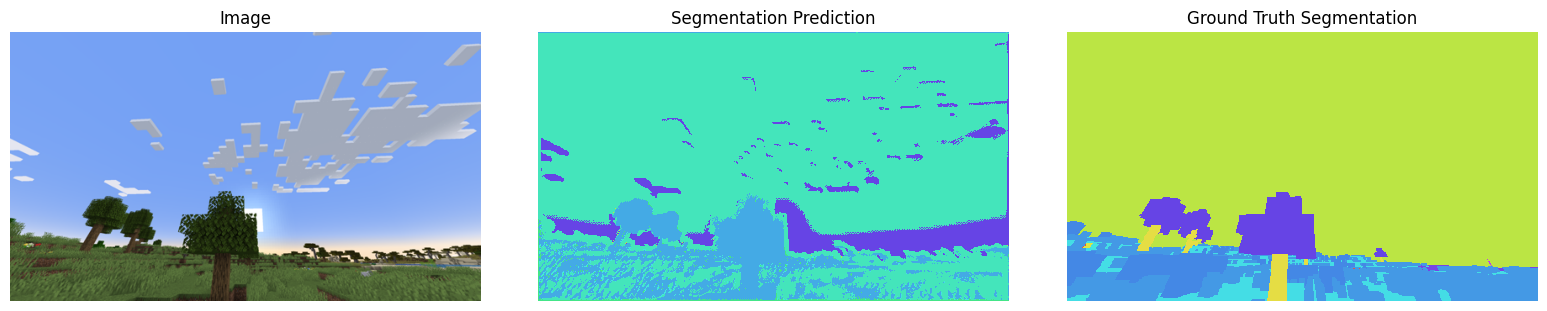

Epoch 1/10, Train Loss: 4.0275, Val Loss: 3.9530


Epoch 2/10: 100%|██████████| 24/24 [00:04<00:00,  5.64iter/s, loss=3.7] 


1.5374675
40


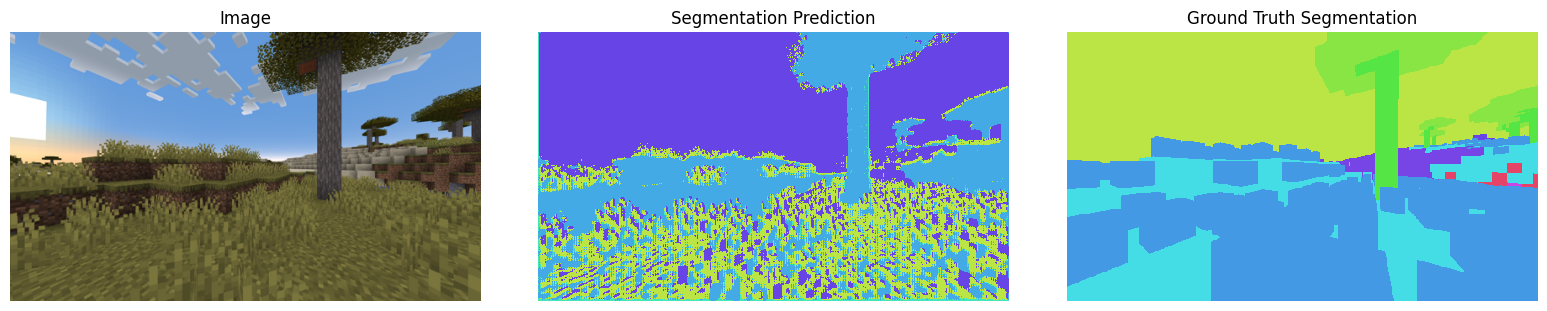

Epoch 2/10, Train Loss: 3.9323, Val Loss: 3.7857


Epoch 3/10: 100%|██████████| 24/24 [00:04<00:00,  5.69iter/s, loss=3.67]


1.89329
46


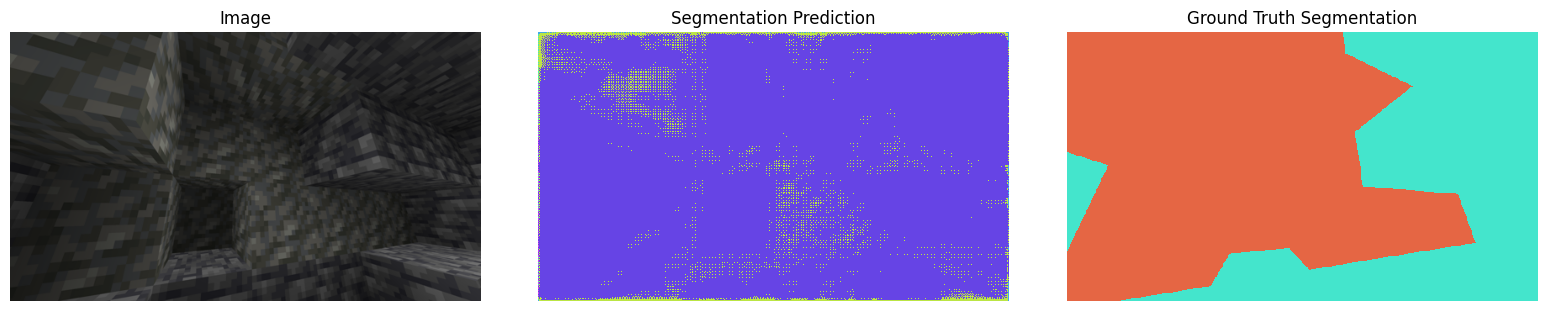

Epoch 3/10, Train Loss: 3.5859, Val Loss: 3.1210


Epoch 4/10: 100%|██████████| 24/24 [00:04<00:00,  5.64iter/s, loss=2.88]


5.4767
46


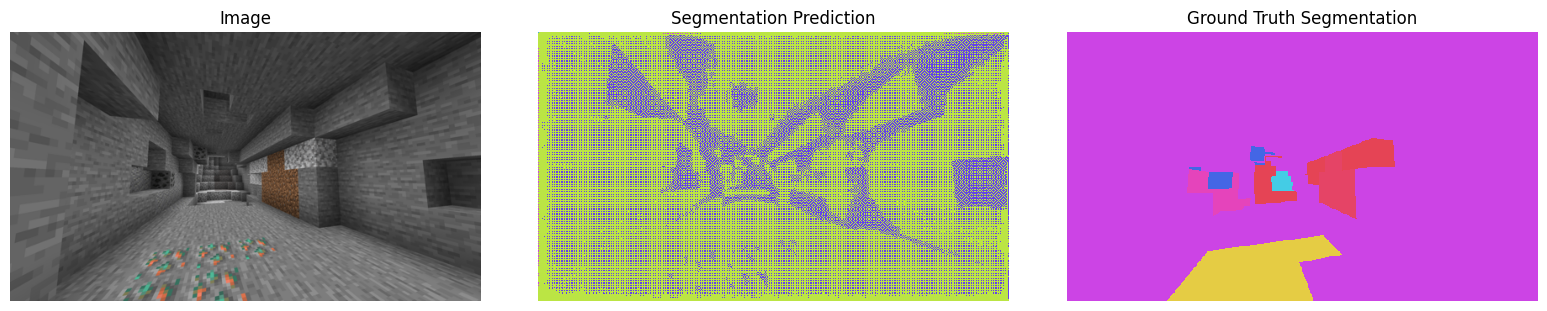

Epoch 4/10, Train Loss: 3.1241, Val Loss: 2.9350


Epoch 5/10: 100%|██████████| 24/24 [00:04<00:00,  5.62iter/s, loss=2.31]


8.884108
46


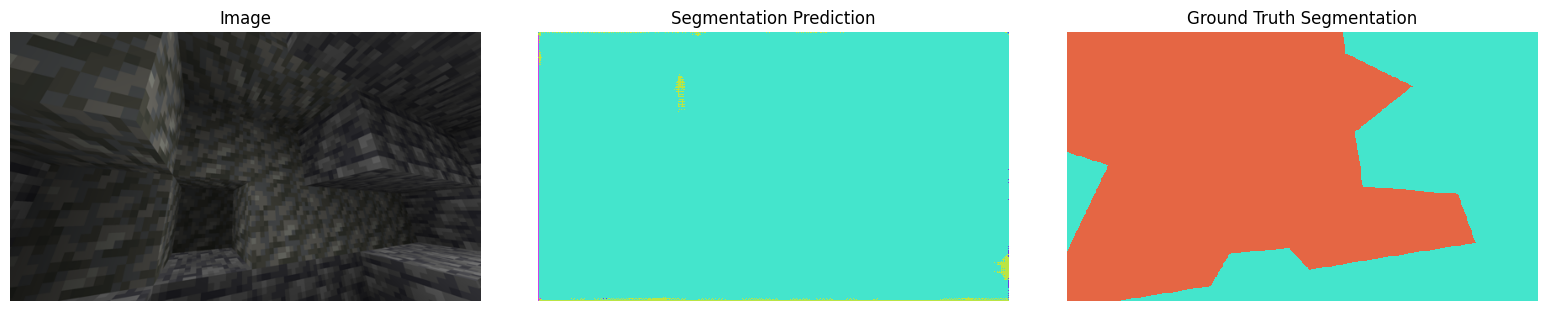

Epoch 5/10, Train Loss: 2.8255, Val Loss: 3.0023


Epoch 6/10: 100%|██████████| 24/24 [00:04<00:00,  5.74iter/s, loss=2.51]


8.430651
46


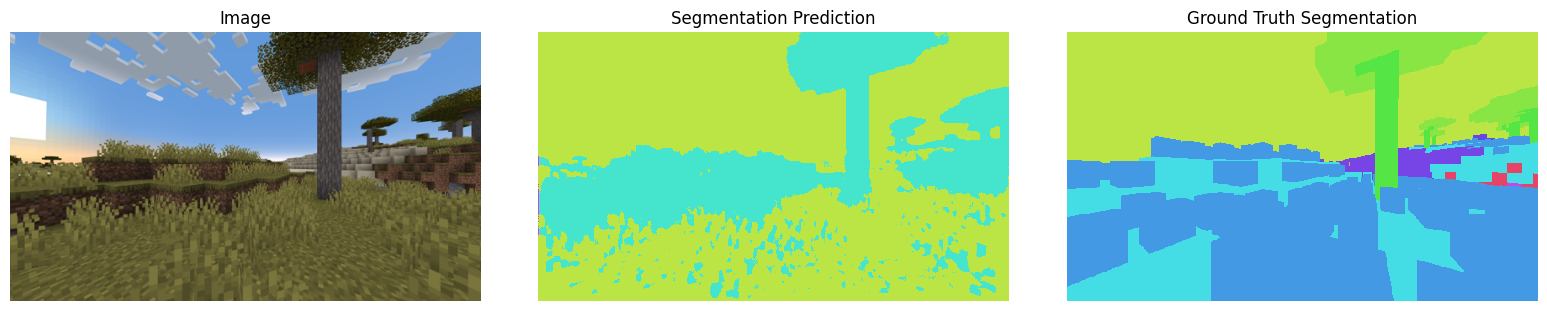

Epoch 6/10, Train Loss: 2.6221, Val Loss: 2.8146


Epoch 7/10: 100%|██████████| 24/24 [00:04<00:00,  5.73iter/s, loss=2.43]


6.795309
46


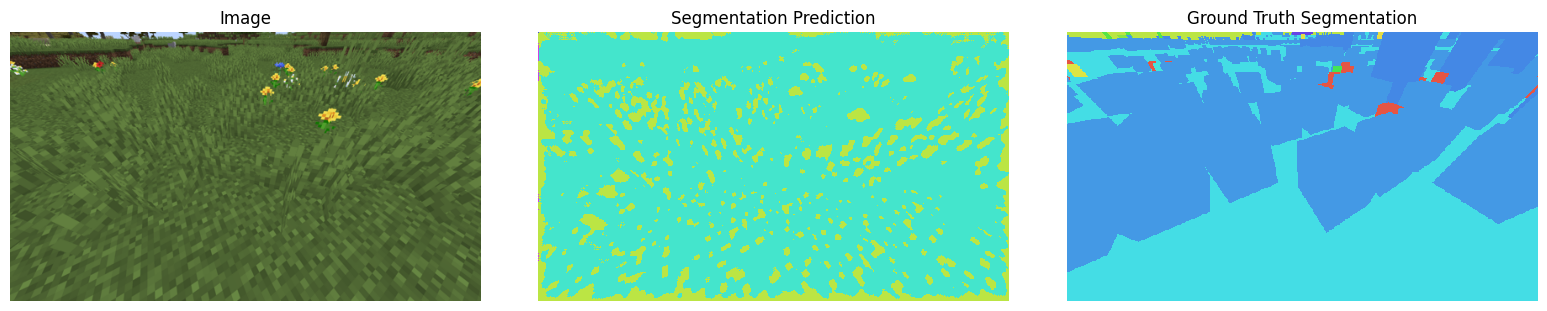

Epoch 7/10, Train Loss: 2.4613, Val Loss: 2.7973


Epoch 8/10: 100%|██████████| 24/24 [00:04<00:00,  5.70iter/s, loss=1.47]


12.44022
46


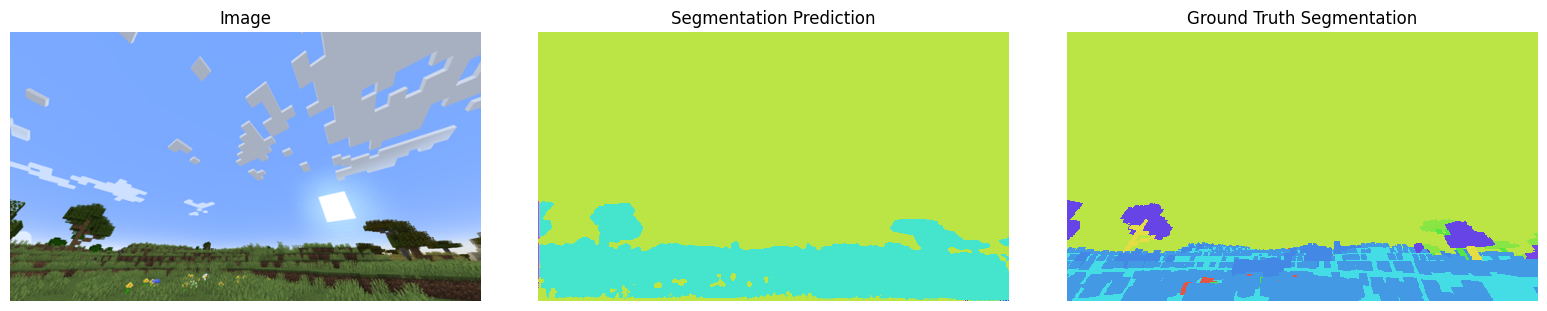

Epoch 8/10, Train Loss: 2.3250, Val Loss: 2.7192


Epoch 9/10: 100%|██████████| 24/24 [00:04<00:00,  5.81iter/s, loss=2.33]


11.343506
46


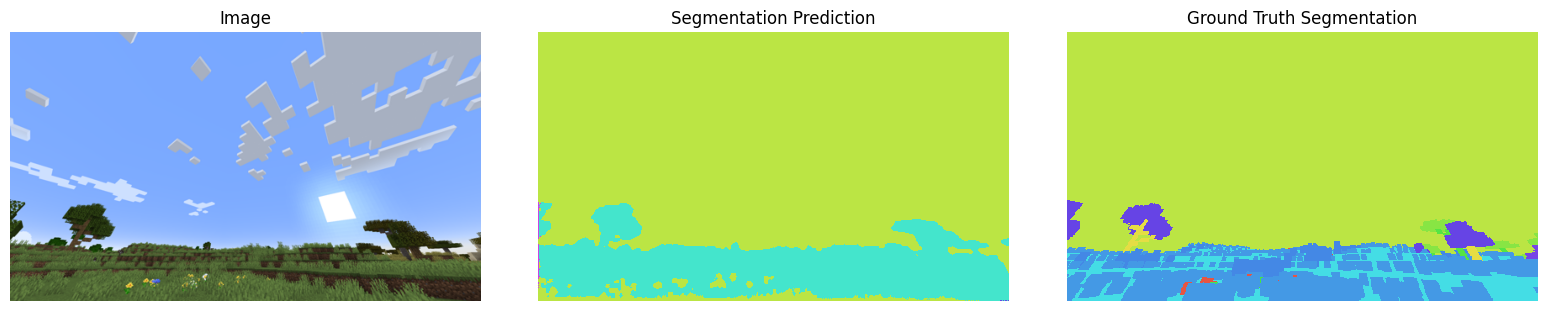

Epoch 9/10, Train Loss: 2.2691, Val Loss: 2.5212


Epoch 10/10: 100%|██████████| 24/24 [00:04<00:00,  5.64iter/s, loss=2.42]


11.355094
46


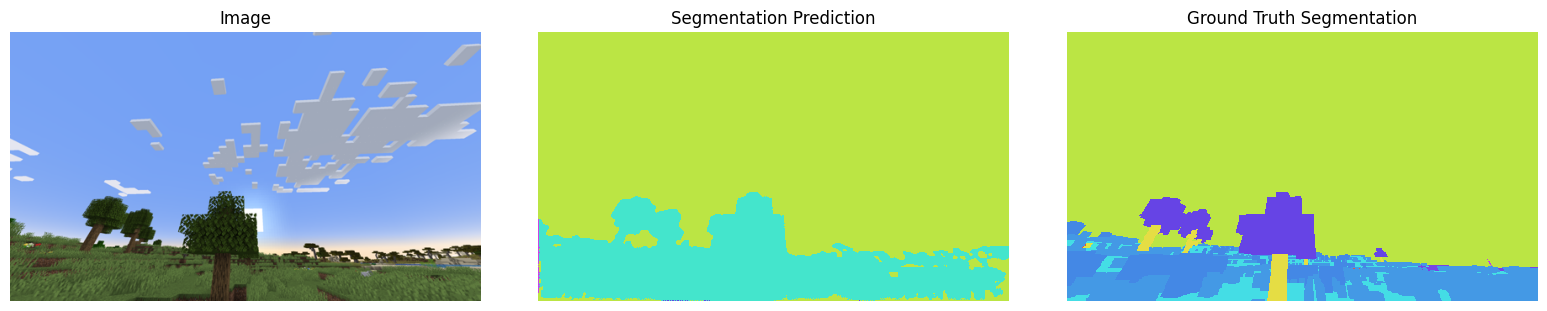

Epoch 10/10, Train Loss: 2.1929, Val Loss: 2.4290


In [8]:
model = DeeperUNet().to(device)

segment_loss_fn = nn.CrossEntropyLoss()
optimizer_segment = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='iter') as pbar:
        start_time = time.time()
        for i, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device).squeeze(1).long()

            optimizer_segment.zero_grad()

            seg_pred = model(images)

            loss = segment_loss_fn(seg_pred, targets)
            loss.backward()
            optimizer_segment.step()

            train_loss += loss.item() * images.size(0)

            pbar.set_postfix({'loss': loss.item()})
            pbar.update(1)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for i, (images, targets) in enumerate(val_loader):
            images = images.to(device)
            targets = targets.to(device).squeeze(1).long()

            seg_pred = model(images)
            loss = segment_loss_fn(seg_pred, targets)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)


    visualize(model)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


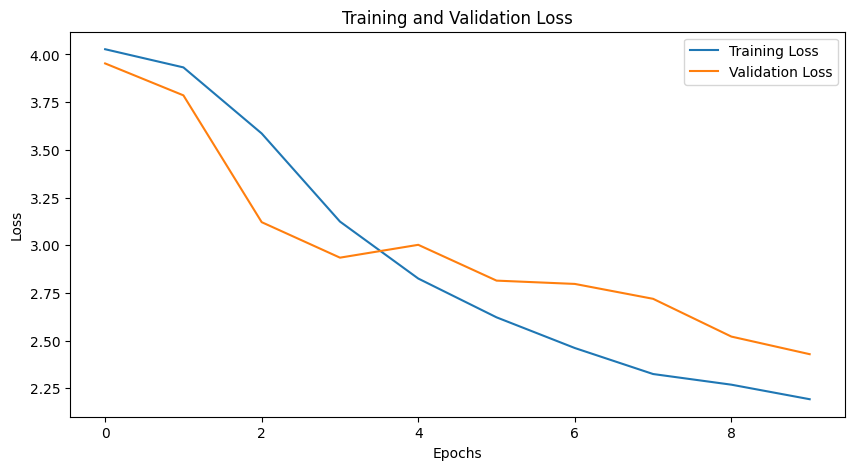

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
torch.save(model.state_dict(), 'model_weights.pth')

In [11]:
model.load_state_dict(torch.load('model_weights.pth'))

C:\Users\evang\AppData\Local\Temp\ipykernel_15788\2178556627.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.352074..6.8645163].


TypeError: Invalid shape (57, 320, 560) for image data

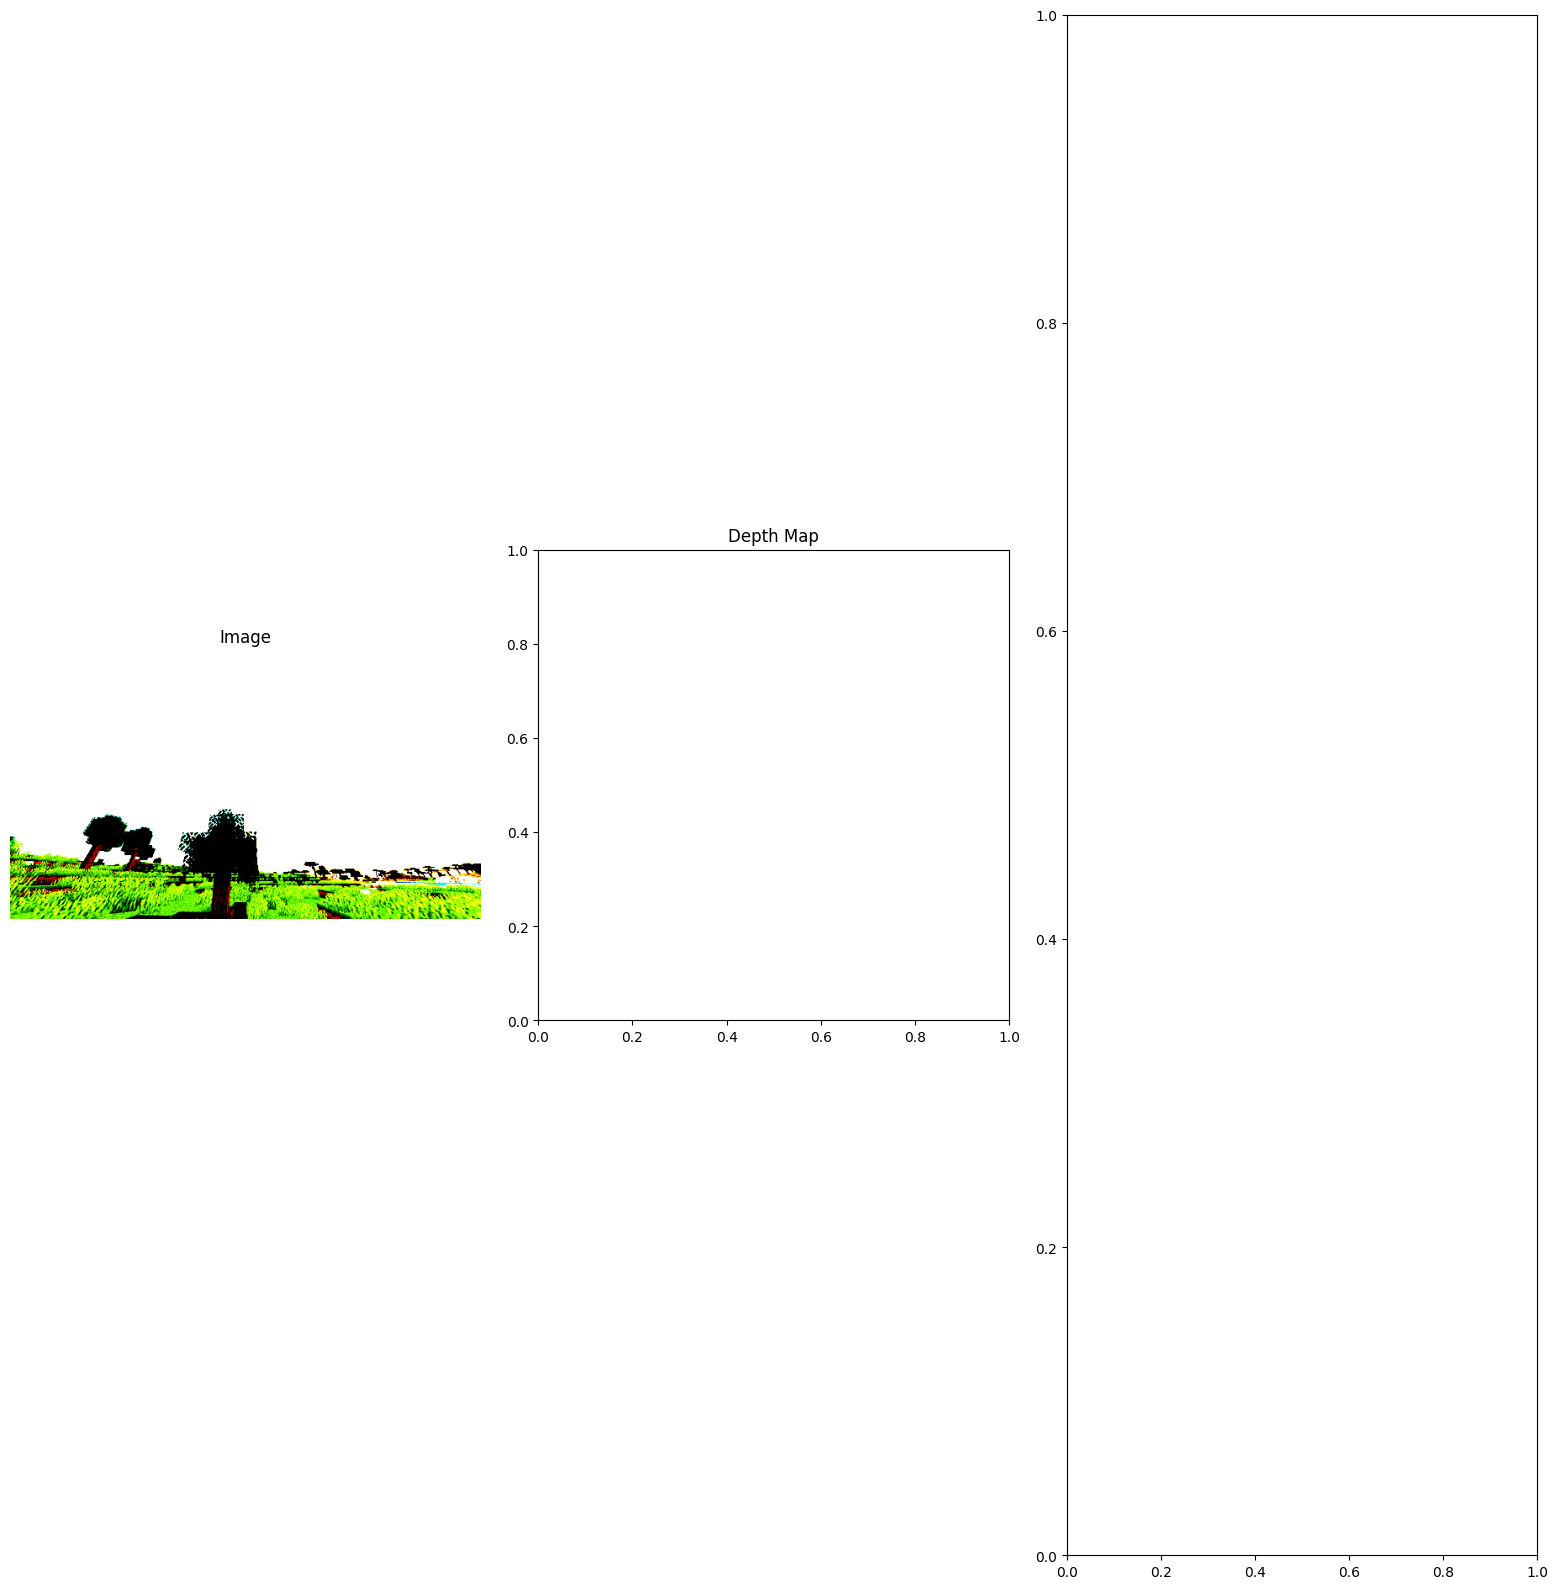

In [12]:
model.eval()

# Test the model on a single image
img, depth = next(iter(val_loader))[0][3].unsqueeze(0).to(device), next(iter(val_loader))[1][3].unsqueeze(0).to(device)
pred = model(img).detach().cpu().squeeze().numpy()

fig, ax = plt.subplots(1, 3, figsize=(16, 16))
fig.tight_layout()

ax[0].set_title('Image')
ax[0].imshow(img.cpu().squeeze(0).permute(1, 2, 0))
ax[0].axis('off')

ax[1].set_title('Depth Map')
ax[1].imshow(pred, cmap='jet', interpolation='nearest')
ax[1].axis('off')

ax[2].set_title('GT Map')
ax[2].imshow(depth.detach().cpu().squeeze(), cmap='jet', interpolation='nearest')
ax[2].axis('off')